# Análisis De Clúster Automático


### Autores: 
    Marisol Correa Henao (mcorreah@unal.edu.co)
                    
### Fecha creación:     
    28/03/2019

### Descripción:        
    Software para Análisis de cluster automático

## Dependencias:       

A continuación se cargan las librerías necesarias

In [1]:
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
import ipywidgets as widgets
from IPython.display import display
from ipyfilechooser import FileChooser
import os

## Parametrización

Se crean los parámetros necesarios

## Funciones para clusterización

Se crean las funciones necesarias para cada etapa de la clusterización

In [ ]:
##
# Leer archivo
##

def leer_datos(ruta, enc, sp):
    data = None
    start_time = time.time()
    
    # Obtenemos la extensión del archivo
    file_ext = ruta.split(".")[-1]
    #data = pd.read_sql(ruta + "." + archivo,cn)
    # Si file_ext es xlsx se leerá la base usando la función de pandas read_excel.
    if file_ext == 'xlsx':
        print("Leyendo el fichero " + ruta)
        
        # INTENTAMOS LEER EL FICHERO CON LA LIBRERÍA PANDAS DE PYTHON.
        try:
            data = pd.read_excel(ruta, na_values = 'None')            
        # Si falla la lectura del archivo finalizamos la ejecución y escribimos en el log
        except Exception as e:
            msg = "ERROR: " + str(e)

            # Finalizamos el programa y mostramos un mensaje de alerta.
            sys.exit("¡" + msg + "! \n\tLA EJECUCIÓN FINALIZÓ...")

    # Si file_ext es csv se leerá la base usando la función de pandas read_csv.
    elif file_ext == 'csv' or file_ext == 'txt':
        print("Leyendo el fichero " + ruta)

        # Intentamos leer el archivo con pandas
        try:
            data = pd.read_csv(ruta, sep = sp,  low_memory = False, na_values = 'None')            
        # Si falla la lectura del archivo finalizamos la ejecución y escribimos en el log.
        except Exception as e:
            msg = "ERROR: " + str(e)

            # Finalizamos el programa y mostramos un mensaje de alerta.
            sys.exit("¡" + msg + "! \n\tLA EJECUCIÓN FINALIZÓ...")
            
    # Si file_ext no esta contemplado se escribirá en el log el error correspondiente.
    else:
        msg = "ERROR: La extensión " + ruta.upper() + " no es válida para la lectura de datos."

        # Finalizamos el programa y mostramos un mensaje de alerta.
        sys.exit("¡" + msg + "! \n\tLA EJECUCIÓN FINALIZÓ...")
        
    tiempo_usado_lc = (time.time() - start_time)/60 
    tiempo_usado_lc = '{:6.2f}'.format(tiempo_usado_lc)
    print("\tArchivo leido satisfactoriamente en:" + str(tiempo_usado_lc) + " minutos")
    print("\tSe cargaron {:,} filas y {:,} columnas".format(data.shape[0], data.shape[1]))    
    
    # Regresamos el fichero leido como un data frame.
    return data, tiempo_usado_lc


##
# variables identificadoras, nulas y a omitir
##
def tipo_variables(datos,ncat):
    ids=[]
    omitir=[]
    for i in datos.columns:
        #ids sugeridos
        if(datos[i].nunique() == datos.shape[0]): ids.append(i)
        # Nulos
        if(all(datos[i].isnull())): omitir.append(i)
        # Si los datos que hay en la columna son siempre el mismo, se da una advertencia
        if(datos[i].nunique() == 1): omitir.append(i)        

    ##
    # Identificar tipo variables
    ##

    tipos={}
    for i in range(0,len(datos.dtypes.value_counts())):
        tipo_dato = datos.dtypes.value_counts().index[i].kind
        tipoj=[]
        for j in range(0,datos.shape[1]):
            if(datos.dtypes[j].kind==tipo_dato):
                tipoj.append(datos.dtypes.index[j])
        tipos[tipo_dato]=tipoj
    '''
    if not np.issubdtype(df_analysis[col].dtype, np.number):
                print(f'La variable {cb}{col}{cc} NO es numerica')
                continue
    '''
    numeric = tipos.get('i',[]) + tipos.get('f',[]) + tipos.get('u',[])
    c = datos[numeric].nunique()
    categoric2 = c[c<=ncat].axes[0].tolist()    
    for i in categoric2: numeric.remove(i)
    categoric =  categoric2 + tipos.get('b',[])+tipos.get('c',[])+tipos.get('m',[])+tipos.get('M',[])+tipos.get('O',[])+tipos.get('S',[])+tipos.get('U',[])+tipos.get('V',[])
    datos[categoric2] = datos[categoric2].astype('str')
    categoric = [x for x in categoric if(x not in omitir and x not in ids) ]   
    numeric = [x for x in numeric if(x not in omitir and x not in ids) ]
    return numeric, categoric, omitir, ids


#######
#  Esta función permite cambiar el tipo de datos
#  2: Si el cambio es a un tipo categórico
#  1: Si el cambio es a un tipo númerico
#  0: Si el cambio es a un tipo omitir
#  -1: Si el cambio es a un tipo identificador
#########
def cambiar_tipo_a(datos,variables,tipo,numeric,categoric,omitir,ids):
    data = datos.copy()
    for i in variables: 
        if(tipo==1): # cambiar a númerico
            if(i in categoric): categoric.remove(i)
            if(i in omitir): omitir.remove(i)
            if(i in ids): ids.remove(i)
            if(i not in numeric): numeric.append(i)
            data[i] = data[i].astype('float',errors="ignore")
        elif(tipo==2): # cambiar a categorico
            if(i in numeric): numeric.remove(i)
            if(i in omitir): omitir.remove(i)
            if(i in ids): ids.remove(i)
            if(i not in categoric): categoric.append(i)
            data[i] = data[i].astype('str',errors="ignore")
        elif(tipo==0): #cambiar a omitir
            if(i in categoric): categoric.remove(i)
            if(i in numeric): numeric.remove(i) 
            if(i in ids): ids.remove(i)
            if(i not in omitir): omitir.append(i)
            data = data.drop(i,axis=1)            
        else: #cambiar a ids
            if(i in categoric): categoric.remove(i)
            if(i in numeric): numeric.remove(i) 
            if(i in omitir): omitir.remove(i)
            if(i not in ids): ids.append(i)
            data = data.drop(i,axis=1)    
        
    return data, numeric, categoric, omitir, ids

##
# Descriptivo (según tipo)
##


def descriptivo_num(datos,col,flag_zeros,ruta):

    # Hallamos los porcentajes de zeros y nulos de la base, correspondiente al despoblamiento.
    perc_zeros =  round((datos[datos[col] == 0].shape[0])*100/datos.shape[0], 2)
    perc_nulls = round((datos[col].shape[0] - datos[col].dropna().shape[0])*100/datos.shape[0], 2)

    # Hallamos el número de valores que no son cero y que tampoco son nulos.
    n_rows_clean = datos[~datos[col].isnull() & (datos[col] != 0)].shape[0]

    if flag_zeros == 1 and datos[[col]].nunique().values[0] != 2: 
        datos = datos[datos[col] != 0]

    # Calculamos el percentil 95 para gráficar correctamente el boxplot, ya que los outliers arruinan la gráfica.
    q95 = datos.quantile(q = 0.95).values[0] if any(datos[col].notnull()) else float('inf')

    # Contamos el número de outliers existentes (valores por encima del 95% de los datos).
    n_outliers = datos[datos[col] > q95].size

    # Creamos un data frame para almacenar las estadísticas
    df_other = pd.DataFrame(["{:0.2f}%".format(perc_zeros),"{:0.2f}%".format(perc_nulls), "{:,}".format(n_rows_clean), "{:,}".format(n_outliers)], 
                            index = ['ceros%', 'nulos%','total', 'outliers'],
                            columns=[col])

    # Calculamos las estadísticas de la columna analizada
    df_stats = np.round(datos[col].describe(percentiles = quantiles, include='all'),2).map("{:,}".format)
    # Eliminamos la columna count que se encuentra repetida
    df_stats = df_stats.drop(["count"])

    # Concatenamos los dos DataFrame de estadísticas
    df_stats = df_other.append(pd.DataFrame(df_stats))
    
    
    # Removemos los datos que se encuentren por encima del 99% de los datos para una mejor visualización de las gráficas.
    q99 = datos.quantile(q = 0.99).values[0] if any(datos[col].notnull()) else float('inf')
    datos = datos[datos[col] <= q99]

    # Creamos la figura y los axes donde se graficará.
    fig, axs = plt.subplots(1,2, figsize = (25, 9.6)) 

    # Agregamos titulo a la figura.
    fig.suptitle(col.upper().replace("_", " "), fontsize = 20)


    # Graficamos la función de densidad de probabilidad.
    plt.axes(axs[0])
    sns.set(style = "whitegrid")
    sns.kdeplot(datos[col], shade=True, color="r", legend=False)
    plt.ylabel("Density", fontsize = 16)
    plt.xlabel(col.replace("_", " "), fontsize = 16)

    # Graficamos el boxplot.
    plt.axes(axs[1])
    plt.grid(False)
    plt.boxplot(datos[col], widths = 0.09)
    plt.ylabel(col)

    # Convertimos las estadísticas en string con separación de miles para mejor visualización en la gráfica.
    df_stats_plot = df_stats[col]

    the_table = table(axs[1], df_stats_plot, loc='upper right', colWidths=[0.15, 0.3, 0.1], cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    plt.ylabel(col.replace("_", " "), fontsize = 16)
    try:
        os.stat(ruta + "\\Graficos")
    except:
        os.mkdir(ruta + "\\Graficos")
    # Guardamos la figura.
    plt.savefig( ruta + "\\Graficos\\" + col + ".png")
    
    # Cerramos la figura para que no se muestre en el notebook
    plt.close()
    
    return df_stats



def descriptivo_cat(datos,col,flag_zeros,ruta):
    # Hallamos los porcentajes de zeros y nulos de la base, correspondiente al despoblamiento.
    perc_zeros =  round((datos[datos[col] == "0"].shape[0])*100/datos.shape[0], 2)
    perc_nulls = round((datos[col].shape[0] - datos[col].dropna().shape[0])*100/datos.shape[0], 2)

    # Hallamos el número de valores que no son cero y que tampoco son nulos.
    n_rows_clean = datos[~datos[col].isnull() & (datos[col] != "0")].shape[0]

    if flag_zeros == 1 and datos[[col]].nunique().values[0] != 2: 
        datos = datos[datos[col] != "0"]
    
    categorias = 100 * dat[col].value_counts() / len(dat[col])
    unicos = dat[col].nunique()
    
    # Convertimos las estadísticas en string con separación de miles para mejor visualización en la gráfica.
    df_stats_plot = pd.DataFrame(["{:0.2f}%".format(perc_zeros),"{:0.2f}%".format(perc_nulls), "{:,}".format(n_rows_clean),"{:,}".format(unicos)], 
                            index = ['ceros%', 'nulos%','total', 'categorias'], 
                            columns = [col])
      # Creamos la figura y los axes donde se graficará.
    fig, axs = plt.subplots(1,3, figsize = (25, 9.6)) 

    # Agregamos titulo a la figura.
    fig.suptitle(col.upper().replace("_", " "), fontsize = 20)
 
    the_table = table(axs[1], df_stats_plot, loc='center', colWidths=[0.15, 0.3, 0.1], cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    plt.ylabel(col.replace("_", " "), fontsize = 16)
    axs[0].axis("off") 
    df_stats_plot = categorias.map(lambda x: "{:0.2f}%".format(x))

    the_table = table(axs[0], df_stats_plot, loc='upper right', colWidths=[0.15, 0.3, 0.1], cellLoc = 'center')
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)
    the_table.scale(2, 2)
    plt.ylabel(col.replace("_", " "), fontsize = 16)
    axs[1].axis("off") 

    #graficos categoricos
    plt.axes(axs[2])
    ax = sns.countplot(y=col, data=datos,order = datos[col].value_counts().index)
    plt.title(col)
    plt.xlabel('%')
    total = len(datos[col])
    for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    try:
        os.stat(ruta + "\\Graficos")
    except:
        os.mkdir(ruta + "\\Graficos")
    plt.savefig( ruta + "\\Graficos\\" + col + ".png")
    
    # Cerramos la figura para que no se muestre en el notebook
    plt.close()

    return categorias
      


def descriptivo_inicial(datos,numeric,categoric,ruta):

    # general
    datos.head(3)
    datos.info()
    datos.describe()
    if len(numeric)>0:
        dat[numeric].skew()
        dat[numeric].kurt()
        correlaciones = dat[numeric].corr()
        fig_size = (25,15)
        fig, ax = plt.subplots(figsize = fig_size)
        sns.heatmap(correlaciones, annot=True, fmt='.4f', 
                cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
        try:
            os.stat(ruta + "\\Graficos")
        except:
            os.mkdir(ruta + "\\Graficos")
        fig.savefig(ruta + "\\Graficos\\" + "correlaciones.png", bbox_inches = "tight")
        plt.close()
        for i in numeric:
            descriptivo_num(datos,i,zeros,ruta)
    for i in categoric:
        descriptivo_cat(datos,i,zeros,ruta)                                            
        
##
# datos atípicos y faltantes
##
def manejo_datos(datos,tipo,accion,col,valor):
    #accion:0 remover
    #acción:-1 imputar valor
    #acción:1 media
    #acción:2 mediana
    #acción:3 moda
    #tipo:0 atípico
    #tipo:1 nulo
    data = datos.copy()
    for i in col:        
        q99 = datos.quantile(q = 0.99).values[0] if any(datos[i].notnull()) else float('inf')
        if(accion!=0): #cambiar valor
            if(accion==1 and np.issubdtype(data[i].dtype, np.number)): # mean o moda
                valor = datos[i].mean()
            elif(accion==2 and np.issubdtype(data[i].dtype, np.number)): # mediana
                valor = datos[i].median()
            elif(accion!=-1): #moda o categórico media o mediana
                valor = datos[i].mode()            
            if(tipo==0): #atipico
                data.loc[data[i] > q99, i] = valor
            else: #nulos
                data[i] = data[i].fillna(valor)
        else: #remover
            if(tipo==0): #atipicos
                data = data[data[i] > q99]
            else: #nulos
                data = data[data[i].notna()]              
    return data


##
# Decodificar
##

def decodificar(numeric,categoric,metodnum,metodcat):
    if(len(numeric)>0):
        if(metodnum==1): #min max
            scaler = MinMaxScaler()
        else: #estandarizar
            scaler= StandardScaler()
        scaled_dat = scaler.fit_transform(numeric)
        scaled_dat = pd.DataFrame(scaled_dat, columns=numeric.columns)
    else:
        scaled_dat = pd.DataFrame([])
    if(len(categoric)>0):
        if(metodcat==1): #get dummies
            decoder_dat = pd.get_dummies(categoric)
        else: #decodificar, caso de los ordinales
            encoder = LabelEncoder ()
            decoder_dat = encoder.fit_transform(categoric)
    else:
        decoder_dat = pd.DataFrame([])
    data = pd.concat([scaled_dat, decoder_dat], axis=1)
    
    return data
        
        
    

##
# nro cluster
##
def get_elbow(datos,min,max,metodo):
    if(metodo==1):
        metric = 'calinski_harabasz'
    elif(metodo==2):
        metric = 'silhouette'
    else:
        metric = 'distortion'
    visualizer = KElbowVisualizer(KMeans(), k=(min,max),metric=metric)
    warnings.filterwarnings('error')
    try:
        os.stat(ruta + "\\Graficos")
    except:
        os.mkdir(ruta + "\\Graficos")
    try:
        visualizer.fit(datos)
        visualizer.show( ruta + "\\Graficos\\codo.png")
    except Warning:
        print('el rango no permite hallar un número óptimo de cluster')        
        return 3
    return visualizer.elbow_value_
       
##
# cluster
##
def cluster(datos,n,metodo):
    if(metodo==1):
        model = KMeans(n_clusters=n)
    #if(metodo==2):
     #   model = KMedoids(n_clusters=n)
    return model.fit(datos).labels_


##
# interpretación
##
def interpretacion(datos,numeric,categoric):   
     
#porcentaje en cada cluster
    ax = sns.countplot(y='cluster', data=datos)
    plt.title('Porcentaje Cluster')
    plt.xlabel('%')
    total = len(datos['cluster'])
    for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    try:
        os.stat(ruta + "\\Resultados")
    except:
        os.mkdir(ruta + "\\Resultados")
    plt.savefig( ruta + "\\Resultados\\general.png")

#boxplots

            # Gráficamos un boxplot por cada clúster
    for col in numeric:
        fig, axs = plt.subplots(1,2, figsize = (25,9.6)) 

    # Agregamos titulo a la figura.
        fig.suptitle(col.upper().replace("_", " "), fontsize = 20)
        grouped_data = datos[[col,'cluster']].groupby('cluster')
        # Estadísticas para todas las columnas numéricas por cluster
        tab = np.round(grouped_data.describe(),2)
        
        the_table = table(axs[1], tab, loc='center',cellLoc = 'center')
        the_table.set_fontsize(14)
        the_table.scale(1.3, 2)
        axs[1].axis("off")  
        
        plt.axes(axs[0])
        ax = sns.boxplot(y = col, x = 'cluster', data = datos, orient = "v", width = 0.45, palette = "Set1")
        
                    # Pesonalizamos la gráfica
        ax.set_ylabel(col.replace("_", " "), fontsize = 15)
        ax.set_xlabel("Número clúster", fontsize = 15)
        try:
            os.stat(ruta + "\\Resultados")
        except:
            os.mkdir(ruta + "\\Resultados")
        plt.savefig( ruta + "\\Resultados\\" + col + ".png")
        

   # Gráfico de barras de sobreviviviente segun clase
    for col in categoric:
        fig, axs = plt.subplots(2,1, figsize = (25,9.6)) 

    # Agregamos titulo a la figura.
        fig.suptitle(col.upper().replace("_", " "), fontsize = 20)
        tab = np.round(pd.crosstab(index=datos[col],
            columns=datos['cluster']).apply(lambda r: r/r.sum() *100,axis=0),2)
        the_table = table(axs[0], tab, loc='center',cellLoc = 'center')
        axs[0].axis("off")    
        try:
            os.stat(ruta + "\\Resultados")
        except:
            os.mkdir(ruta + "\\Resultados")
        plt.savefig( ruta + "\\Resultados\\" + col + "2.png")     
        plt.axes(axs[1])
        tab.plot(kind='bar')       
        plt.savefig( ruta + "\\Resultados\\" + col + ".png")                    

       
def principales_vars(datos_norm):
    perfilado = datos_norm.groupby('cluster').mean() 
    perfilado.reset_index( drop = False, inplace = True )
    perfilado['__fac_x__'] = perfilado['cluster'].map(lambda x: f'Cluster {x+1}')                                       
    perfilado.drop('cluster', axis = 1, inplace = True )    

    fac_y = list(perfilado.drop( ['__fac_x__'], axis = 1 ).columns)
    fac_x = list(perfilado['__fac_x__'])      

    list_of_lists = [ [name] * len(perfilado['__fac_x__'].unique()) for name in fac_y ]
    y = [ itm for list_ in list_of_lists for itm in list_ ]
    x = fac_x * len(fac_y)
    
    tup_key = list( zip(y, x) )
    medias_clus = [ perfilado.loc[ perfilado["__fac_x__"] == tup[1], tup[0] ].values[0]  for tup in tup_key ]                  
    data = dict(x = x, y = y, medias_clus = medias_clus)
    
    main_vars = pd.DataFrame(data)

    main_vars = main_vars.sort_values(['x', 'medias_clus'], ascending = [1,0]).groupby('x').apply(lambda x: x)
    
    top_vars = main_vars.groupby('x').head(5).reset_index(drop = True)
    bottom_vars = main_vars.groupby('x').tail(5).reset_index(drop = True)
    main_vars = pd.concat([top_vars, bottom_vars])
    main_vars = main_vars.sort_values('x')

    return main_vars
##
# exportar
##

def exportar(datos,ruta_salida,nombre_archivo,formato):
    if(formato==1):
        datos.to_excel(ruta_salida+nombre_archivo+".xlsx")
    else:
        datos.to_csv(ruta_salida+nombre_archivo+".csv")
        
def on_button_clicked(a):
    print("CAMBIOS:")
    global numn,catn,idsn,omitn
    numn=[]
    catn=[]
    idsn=[]
    omitn=[]
    for i in num2:
        if(i.value!='Numerica'):
            if i.value == 'Categorica':
                catn.append(i.description)
            elif i.value == 'Identificador':
                idsn.append(i.description)
            else:
                omitn.append(i.description)
            print('cambió ' + str(i.description) + " de Númerica a: " + str(i.value))
    for i in cat2:
        if(i.value!='Categorica'):
            if i.value == 'Numerica':
                numn.append(i.description)
            elif i.value == 'Identificador':
                idsn.append(i.description)
            else:
                omitn.append(i.description)
            print('cambió ' + str(i.description) + " de Categorica a: " + str(i.value))
    for i in ids2:
        if(i.value!='Identificador'):
            if i.value == 'Numerica':
                numn.append(i.description)
            elif i.value == 'Categorica':
                catn.append(i.description)
            else:
                omitn.append(i.description)
            print('cambió ' + str(i.description) + " de Identificador a: " + str(i.value))
    for i in omit2:
        if(i.value!='Omitir'):
            if i.value == 'Numerica':
                numn.append(i.description)
            elif i.value == 'Categorica':
                catn.append(i.description)
            else:
                idsn.append(i.description)
            print('cambió ' + str(i.description) + " de Omitir a: " + str(i.value))
            
def on_button_clicked2(a):
    for i in cambios_deco:
        if(i.value!=i.description):
            base_dec[i.placeholder] = base_dec[i.placeholder].map({i.description:i.value},na_action='ignore')

In [3]:
catn=[]
numn=[]
omitn=[]
idsn=[]
num2 = []
cat2 = []
ids2 = []
omit2 = []
# Si flag_zeros = 1 se realiza un análisis excluyendo los ceros.
zeros = 0
ncat = 10
quantiles = [0.01, 0.05, 0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
variables = []
tipo_cambio = 0
min = 2
max = 6

## Lectura de datos

In [ ]:
fc = FileChooser('/')
display(fc)
sep=widgets.RadioButtons( options=[';', ',', ('tab','\t')], description ='Separador',disabled=False)
enco=widgets.RadioButtons( options=['ISO-8859-1', 'ascii', 'latin_1','utf_8'], description ='Encoding',disabled=False)
opciones=widgets.HBox([sep,enco])
display(opciones)

In [ ]:
ruta = fc.selected_path
archivo = fc.selected_filename

In [6]:
dat,tiempo = leer_datos(ruta + '\\' + archivo,enco.value,sep.value)

Leyendo el fichero C:\Users\marcorhe\Documents\tdg-software.xlsx
	Archivo leido satisfactoriamente en:  0.00 minutos
	Se cargaron 10 filas y 4 columnas


In [7]:
dat

,Herramienta,Ventajas,Desventajas,Solución propuesta a través del software a desarrollar
0,Python,•\tContiene una variedad de paquetes que permi...,· Requiere un conocimiento de las técni...,•\tAl desarrollarse en python se dispone de la...
1,Spark,•\tPermite manejo de grandes volúmenes datos y...,•\tRequiere un conocimiento de las técnicas a ...,•\tAl desarrollarse en python se dispone de la...
2,Mahout,•\tPermite manejo de grandes volúmenes datos y...,•\tRequiere un conocimiento de las técnicas a ...,•\tSe adiciona una interfaz gráfica que permit...
3,R,•\tContiene una variedad de paquetes que permi...,"•\tAl no ser un lenguaje muy rápido, con ciert...",•\tSe adiciona una interfaz gráfica que permit...
4,SAS,•\tInterfaz amigable y rapida para cualquier u...,•\tRequiere un conocimiento de las técnicas a ...,•\tGratuita\n•\tSe analiza cada tipo de dato p...
5,SPSS,•\tPermite integración con otras herramientas\...,•\tRequiere un conocimiento de las técnicas a ...,•\tAl desarrollarse en python se dispone de la...
6,ORANGE,•\tInterfaz amigable y rapida para cualquier u...,•\tRequiere un conocimiento de las técnicas a ...,•\tSe analiza cada tipo de dato para ofrecer l...
7,RAPIDMINER,•\tPermite integración con otras herramientas\...,•\tRequiere un conocimiento de las técnicas a ...,•\tAl desarrollarse en python se dispone de la...
8,WEKA,•\tInterfaz amigable con el usuario\n•\tContie...,•\tRequiere un conocimiento de las técnicas a ...,•\tAl desarrollarse en python se dispone de la...
9,KNIME,•\tEficiencia en la depuración y manejo descri...,•\tRequiere un conocimiento de las técnicas a ...,•\tSe analiza cada tipo de dato para ofrecer l...


## Tipo de Variables

In [8]:
num,cat,omit,ids = tipo_variables(dat,ncat)

In [9]:
for i in num:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Numerica',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    num2.append(aux)
    
for i in cat:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Categorica',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    cat2.append(aux)
    
for i in ids:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Identificador',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    ids2.append(aux)
    
for i in omit:
    aux = widgets.ToggleButtons(
    options=['Numerica', 'Categorica', 'Identificador','Omitir'],
    value='Omitir',
    # rows=10,
    description=i,
    disabled=False
    )
    display(aux)
    #aux.observe(on_click, 'value')
    omit2.append(aux)
select_button = widgets.Button(
    description='OK', # User defined
    disabled=False
)
display(select_button)
select_button.on_click(on_button_clicked)

ToggleButtons(description='Solución propuesta a través del software a desarrollar', index=1, options=('Numeric…

ToggleButtons(description='Herramienta', index=2, options=('Numerica', 'Categorica', 'Identificador', 'Omitir'…

ToggleButtons(description='Ventajas', index=2, options=('Numerica', 'Categorica', 'Identificador', 'Omitir'), …

ToggleButtons(description='Desventajas', index=2, options=('Numerica', 'Categorica', 'Identificador', 'Omitir'…

Button(description='OK', style=ButtonStyle())

In [10]:
base,num, cat, omit, ids = cambiar_tipo_a(dat,numn,1,num,cat,omit,ids)
base,num, cat, omit, ids = cambiar_tipo_a(base,catn,2,num,cat,omit,ids)
base,num, cat, omit, ids = cambiar_tipo_a(base,idsn,-1,num,cat,omit,ids)
base,num, cat, omit, ids = cambiar_tipo_a(base,omitn,0,num,cat,omit,ids)
numn=[]
catn=[]
omitn=[]
idsn=[]

## Análisis Descriptivo

In [11]:
descriptivo_inicial(base,num,cat,ruta)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   Herramienta                                             10 non-null     object
 1   Ventajas                                                10 non-null     object
 2   Desventajas                                             10 non-null     object
 3   Solución propuesta a través del software a desarrollar  10 non-null     object
dtypes: object(4)
memory usage: 448.0+ bytes


C:\Users\marcorhe\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\marcorhe\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


## Imputar Variables

### Datos Atípicos

In [ ]:
accion_atip = widgets.RadioButtons(
    options=[('Imputar',-1), ('Reemplazar con Media',1), ('Reemplazar con Mediana',2),('Reemplazar con Moda',3),('Remover',0)],
     value=-1,
    description='¿Qué desea hacer con los datos atípicos?:',
    disabled=False
)
atip = widgets.Text(
    value='0',
    placeholder='Valor para reemplazar datos atípicos',
    description='Por Valor:',
    disabled=False
)
opc_atip=widgets.HBox([accion_atip,atip])
display(opc_atip)

In [13]:
#accion:0 remover
#acción:-1 imputar valor
#acción:1 media
#acción:2 mediana
#acción:3 moda
#tipo:0 atípico
#tipo:1 nulo
#if(accion_atip.label == 'Remover'):
#    base_dep0 = manejo_datos(base,0,0,num,0) #remover atipicos
#elif(accion_atip.label == 'Reemplazar con Media'):
#    base_dep0 = manejo_datos(base,0,1,num,0) #atipicos cambiar a la media
#elif(accion_atip.label == 'Reemplazar con Mediana'):
#    base_dep0 = manejo_datos(base,0,2,num,0) #atipicos cambiar a mediana
#elif(accion_atip.label == 'Reemplazar con Moda'):
#    base_dep0 = manejo_datos(base,0,3,num,0) #atipicos cambiar a moda
#else:
#    base_dep0 = manejo_datos(base,0,-1,num,int(atip.value)) #atipicos cambiar a valor

base_dep0 = manejo_datos(base,0,accion_atip.value,num,int(atip.value)) 

### Datos Nulos

In [14]:
accion_nul = widgets.RadioButtons(
    options=['Imputar', 'Reemplazar con Media', 'Reemplazar con Mediana','Reemplazar con Moda','Remover'],
     value='Imputar',
    description='¿Qué desea hacer con los datos nulos?:',
    disabled=False
)
nul = widgets.Text(
    value='0',
    placeholder='Valor para reemplazar datos nulos',
    description='Por Valor:',
    disabled=False
)
opc_nul=widgets.HBox([accion_nul,nul])
display(opc_nul)

In [15]:
#accion:0 remover
#acción:-1 imputar valor
#acción:1 media
#acción:2 mediana
#acción:3 moda
#tipo:0 atípico
#tipo:1 nulo
if(accion_nul.label == 'Remover'):
    base_dep1 = manejo_datos(base_dep0,1,0,num,0) #remover nulos
elif(accion_nul.label == 'Reemplazar con Media'):
    base_dep1 = manejo_datos(base_dep0,1,1,num,0) #nulos cambiar a la media
elif(accion_nul.label == 'Reemplazar con Mediana'):
    base_dep1 = manejo_datos(base_dep0,1,2,num,0) #nulos cambiar a mediana
elif(accion_nul.label == 'Reemplazar con Moda'):
    base_dep1 = manejo_datos(base_dep0,1,3,num,0) #nulos cambiar a moda
else:
    base_dep1 = manejo_datos(base_dep0,1,-1,num,int(nul.value)) #nulos cambiar a valor

## Preparación de variables

### Variables a conservar sin decodificar

In [16]:
col_conserv=[]
for i in base_dep1.columns:
    col_conserv.append(widgets.Checkbox(
    value=False,
    description=i,
    disabled = False
    ))
opc_conserv = widgets.HBox(col_conserv)   
display(opc_conserv)

In [17]:
var_conserv=[]
for i in range(0,len(base_dep1.columns)):
    if(col_conserv[i].value!=False):
        var_conserv.append(i)
if(len(var_conserv)>0): 
    conserv = base_dep1.iloc[:,var_conserv]
else:
    conserv = pd.DataFrame([])

### Variables a decodificar

### Númericas

In [18]:
col_num=[]
col_cat=[]
for i in num:
    col_num.append(widgets.Dropdown(
    options=['Min-Max', 'Estandarizar'],
    value='Min-Max',
    description=i,
    disabled=False,
))
opc_num = widgets.HBox(col_num)   
for i in cat:
    col_cat.append(widgets.Dropdown(
    options=['Dummies', 'Decodificar'],
    value='Dummies',
    description=i,
    disabled=False,
))
opc_cat = widgets.HBox(col_cat) 
opc_base = widgets.VBox([opc_num,opc_cat])
display(opc_base)

In [20]:
cat_uno = []
cat_cero =[]
num_uno = []
num_cero = []
for i in col_cat:
    if(i.value=='Dummies'):
        cat_uno.append(i.description)
    else:
        cat_cero.append(i.description)
        
for i in col_num:
    if(i.value=='Min-Max'):
        num_uno.append(i.description)
    else:
        num_cero.append(i.description)
if(len(num_uno)==0):
    num_uno = pd.DataFrame([]) 
else: 
    num_uno = base_dep1.iloc[:,num_uno]
if(len(num_cero)==0):
    num_cero = pd.DataFrame([]) 
else: 
    num_cero = base_dep1.iloc[:,num_cero]
    
if(len(cat_uno)==0):
    cat_uno = pd.DataFrame([]) 
else: 
    cat_uno = base_dep1.loc[:,cat_uno]
if(len(cat_cero)==0):
    cat_cero = pd.DataFrame([]) 
else: 
    cat_cero = base_dep1.loc[:,cat_cero]

In [21]:
base_dec0 = decodificar(num_uno,cat_uno,1,1) #min max sino estandarizar y get dummies sino decodificar
base_dec1 = decodificar(num_cero,cat_cero,0,0) #min max sino estandarizar y get dummies sino decodificar
base_dec = pd.concat([base_dec0,base_dec1,conserv], axis=1)

### Modificar variables

In [ ]:
cambios_deco = []
for i in cat_uno.columns:
    for j in cat_uno[i].unique():
        cambios_deco.append(widgets.Text(
        value=j,
        placeholder=i,
        description=j,
        disabled=False
        ))
opc_cam = widgets.VBox(cambios_deco) 
display(opc_cam)
select_button2 = widgets.Button(
    description='OK', # User defined
    disabled=False
)
display(select_button2)
select_button2.on_click(on_button_clicked2)

## Seleccionar Número Clúster

In [ ]:
min=widgets.Text(
        value=2,
        placeholder='ingrese mínimo cluster',
        description='Min',
        disabled=False
        )
max=widgets.Text(
        value=5,
        placeholder='ingrese máximo cluster',
        description='max',
        disabled=False
        )
met_nclu=widgets.Dropdown(
    options=[('calinski_harabasz',1), ('silhouette',2), ('distortion',0)],
    value=0,
    description='Metodo:',
    disabled=False,
)
opc_nro_clu = widgets.HBox(min,max,met_nclu) 
display(opc_nro_clu)

el rango no permite hallar un número óptimo de cluster


RuntimeWarning: Glyph 9 missing from current font.

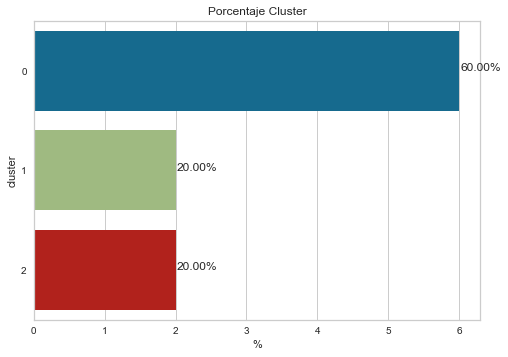

RuntimeWarning: Glyph 9 missing from current font.

<Figure size 1800x691.2 with 2 Axes>

In [24]:
#1: calinski_harabasz
#2: silhouette
#0: distortion
nclusters = get_elbow(base_dec,min.value,max.value,met_nclu.value)

## Clúster

In [ ]:
met_clu=widgets.Dropdown(
    options=[('Kmeans',1), ('Kmedoids',2), ('Kprototypes',0)],
    value=0,
    description='Metodo:',
    disabled=False,
)
display(met_clu)

In [ ]:
dat['cluster'] = cluster(base_dec,nclusters,1)

## Resultados

In [ ]:
interpretacion(dat,num,cat)
principales_vars(datos_norm)

## Exportar

In [ ]:
ruta_salida=widgets.Text(
        value=ruta,
        placeholder='¿Dónde quiere guardar resultados?',
        description='¿Dónde quiere guardar resultados?',
        disabled=False
        )
nombre_archivo=widgets.Text(
        value="resultados",
        placeholder='¿nombre archivo guardar resultados?',
        description='¿nombre archivo guardar resultados?',
        disabled=False
        )
formato_salida=widgets.Dropdown(
    options=[('xlsx',1), ('csv',0)],
    value=1,
    description='Formato Resultado:',
    disabled=False,
)
opc_exp = widgets.HBox(ruta_salida,nombre_archivo,formato_salida) 
display(opc_exp)

In [ ]:
# formato:
# 1: xlsx
# 2. csv
exportar(dat,ruta_salida.value,nombre_archivo.value,formato_salida.value)

In [ ]:
toggle = widgets.ToggleButton(description='Toggle visible')
to_hide = widgets.IntRangeSlider(description = 'hide me')
display(to_hide)
display(toggle)

def hide_slider(widg):
    if widg['new']:
        to_hide.layout.display = 'none'
    else:
        to_hide.layout.display = ''

toggle.observe(hide_slider, names=['value'])